In [1]:
import os 
import pandas as pd 
from tf_pipeline.conf import * 
import numpy as np 

In [2]:
df_train_full = pd.read_csv("data/raw/sales_train_evaluation.csv")
df_sample_submission = pd.read_csv("data/raw/sample_submission.csv")
df_sample_submission["order"] = range(df_sample_submission.shape[0])
df_sample_submission = df_sample_submission[df_sample_submission.id.str.contains("validation")]
df_valid = df_train_full.iloc[:, -28:]


df_sample_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F20,F21,F22,F23,F24,F25,F26,F27,F28,order
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30485
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30486
30487,FOODS_3_825_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30487
30488,FOODS_3_826_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30488


In [3]:
def to_val(preds_valid):
    preds_valid = preds_valid[preds_valid.id.str.contains("validation")]
    preds_valid = preds_valid.merge(df_sample_submission[["id", "order"]], on = "id").sort_values("order").drop(["id", "order"], axis = 1).reset_index(drop = True)
    preds_valid = preds_valid.rename(columns = {
        "F1": "d_1914", "F2": "d_1915", "F3": "d_1916", "F4": "d_1917", "F5": "d_1918", "F6": "d_1919", "F7": "d_1920",
        "F8": "d_1921", "F9": "d_1922", "F10": "d_1923", "F11": "d_1924", "F12": "d_1925", "F13": "d_1926", "F14": "d_1927",
        "F15": "d_1928", "F16": "d_1929", "F17": "d_1930", "F18": "d_1931", "F19": "d_1932", "F20": "d_1933", "F21": "d_1934",
        "F22": "d_1935", "F23": "d_1936", "F24": "d_1937", "F25": "d_1938", "F26": "d_1939", "F27": "d_1940", "F28": "d_1941"
        })
    return preds_valid
    

    
horizon = 'validation'
sub_tf = os.path.join(SUBMIT_PATH, "tf_estim_%s.csv" % horizon)
sub_lgb = os.path.join(SUBMIT_PATH, "lgb_estim_%s.csv" % horizon)
sub_hiera = os.path.join(SUBMIT_PATH, "Lgb_store_dpt_lgb_weights_%s.csv" % horizon)

preds_valid_tf = pd.read_csv(sub_tf)
preds_valid_lgb = pd.read_csv(sub_lgb)
preds_valid_h = pd.read_csv(sub_hiera)

preds_valid_tf = to_val(preds_valid_tf)
preds_valid_lgb = to_val(preds_valid_lgb)
preds_valid_h = to_val(preds_valid_h)



In [4]:
preds_valid_tf.values[preds_valid_tf<0].shape

(2425,)

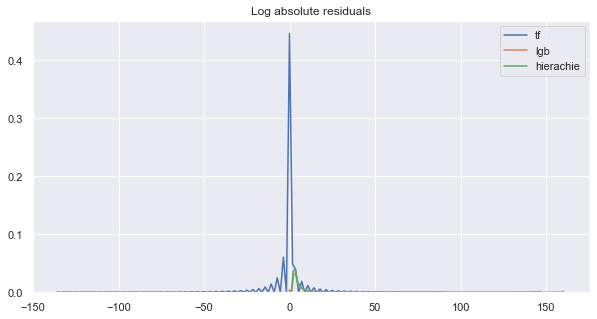

In [5]:
import seaborn as sns 
sns.set()
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,5))
sns.distplot(((preds_valid_tf.values-df_valid.values)),hist=False,label='tf')
sns.distplot(((preds_valid_lgb.values.flatten()-df_sample_submission.iloc[:,1:-1].values.flatten())),hist=False,label='lgb')
sns.distplot(((preds_valid_h.values.flatten()-df_sample_submission.iloc[:,1:-1].values.flatten())),hist=False,label='hierachie')

plt.title('Log absolute residuals')
plt.legend()

In [25]:
# get best performing model in each ts  

err_tf = preds_valid_tf.values.flatten()-df_valid.values.flatten()
err_lgb = preds_valid_lgb.values.flatten()-df_valid.values.flatten()
err_h = preds_valid_h.values.flatten()-df_valid.values.flatten()


-0.027501404947865717 -0.004239190416686355 -0.02413792516472318
0.006731585118013241 0.006458495325833802 0.006745994067117013


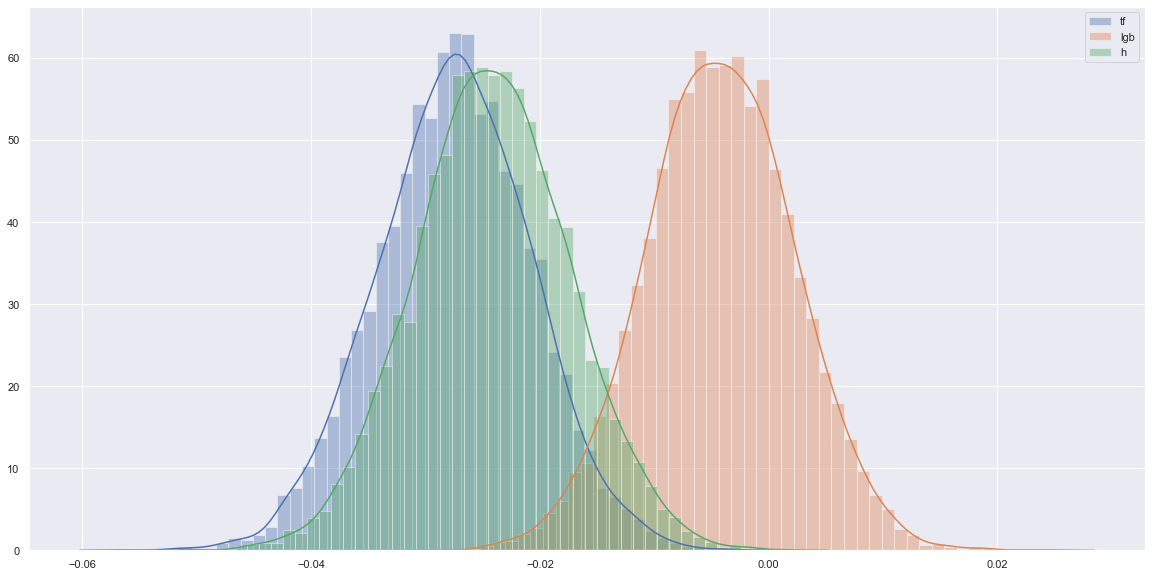

In [56]:
import seaborn as sns 
sns.set()
sample_size = 100000
n_sample = 10000
sem = n_sample/np.sqrt(sample_size)

y_tf = [np.mean(np.random.choice(err_tf,sample_size,replace=True)) for i in range(n_sample)]
y_lgb = [np.mean(np.random.choice(err_lgb,sample_size,replace=True)) for i in range(n_sample)]
y_h = [np.mean(np.random.choice(err_h,sample_size,replace=True)) for i in range(n_sample)]

plt.figure(figsize=(20,10))
sns.distplot(y_tf,label='tf')
sns.distplot(y_lgb,label='lgb')
sns.distplot(y_h,label='h')

plt.legend()
print(np.mean(y_tf),np.mean(y_lgb),np.mean(y_h))
print(np.std(y_tf),np.std(y_lgb),np.std(y_h))